In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from scipy.stats import norm

In [2]:

# S: underlying stock price
# K: Option strike price
# r: risk free rate
# D: dividend value
# vol: Volatility
# T: time to expiry (assumed that we're measuring from t=0 to T)

def d1_calc(S, K, r, vol, T, t):
    # Calculates d1 in the BSM equation
    return (np.log(S/K) + (r + 0.5 * vol**2)*(T-t))/(vol*np.sqrt(T-t))

def BS_call(S, K, r, vol, T, t):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T)*norm.cdf(d2)

def BS_put(S, K, r, vol, T, t):
    return BS_call(S, K, r, vol, T, t) - S + np.exp(-r*(T-t))*K

def BS_binary_call(S, K, r, vol, T, t):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol * np.sqrt(T-t)
    return np.exp(-r*T)*norm.cdf(d2)

def BS_binary_put(S, K, r, vol, T, t):
    return BS_binary_call(S, K, r, vol, T,t) - S + np.exp(-r*(T-t))*K

###########################################################################
#1st Order Greeks
def delta(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol * np.sqrt(T-t) 
    if(otype == "call"):
        delta = norm.cdf(d1)
    elif(otype == "put"):
        delta = -norm.cdf(-d1)
    return delta


def vega(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    return S * norm.pdf(d1) * np.sqrt(T-t)

def rho(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol*np.sqrt(T-t)
    
    if(otype == "call"):
        rho = K*(T-t)*np.exp(-r*(T-t))*norm.cdf(d2)
    elif(otype == "put"):
        rho = -K*(T-t)*np.exp(-r*(T-t))*norm.cdf(-d2)
    return rho

def theta(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol*np.sqrt(T-t)
    
    if(otype == "call"):
        #theta = (S*norm.pdf(d1)*vol / (2*np.sqrt(T-t))) - r*K*np.exp(-r*(T-t))*norm.cdf(d2)
        theta = ((S*norm.pdf(d1)*vol)/(2*np.sqrt(T-t))) - r*K*np.exp(-r*(T-t))*norm.cdf(d2)
    elif(otype == "put"):
        theta = -(S*norm.pdf(d1)*vol / (2*np.sqrt(T-t))) + r*K*np.exp(-r*(T-t))*norm.cdf(d2)

    return theta

def omega(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol * np.sqrt(T-t)
    
    if(otype == "call"):
        omega = (np.exp(-(T-t))*norm.cdf(d1))*(S/(BS_call(S, K, r, vol, T, t)))
    elif(otype == "put"):
        omega = -np.exp(-(T-t))*norm.cdf(-d1)*(S/(BS_put(S, K, r, vol, T, t)))

    return omega

#2nd Order Greeks
def gamma(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    gamma = (norm.pdf(d1)) / (S * vol * np.sqrt(T-t))
    
    return gamma

def charm(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol*np.sqrt(T-t)
    charm = -norm.pdf(d1)*(2*r*(T-t) - d2*vol*np.sqrt(T-t))/(2*(T-t)*vol*np.sqrt(T-t))

    return charm

def vanna(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    return norm.pdf(d1) * np.sqrt(T-t) * (1-d1)



In [3]:
# Zakamoulin

r = 0
lam =.02 #transaction cost IB
vol = 0.3
T = 1
t = 0
S=105
K = 100
low_gamma = 1 #absolute risk aversion  



def param_H_0(S, K, r, vol, T, t, otype):
    H_0 = lam/(low_gamma*S*(vol**2)*(T-t))
    return H_0


def param_H_w(S, K, r, vol, T, t, otype):
    H_w = 1.18*(((lam**0.31) * (T-t)**0.1)/((vol**0.25)*np.exp(0.15*(T-t)))) *((gamma(S, K, r, vol, T, t, otype)/low_gamma)**0.5)
    return H_w


def variance_modfied(S, K, r, vol, T, t, otype):
    var_m = vol**2*((1 + 6.85*((lam**0.78 * (T-t)**0.1)/(vol**0.25 *np.exp(0.2 * (T-t))))*(low_gamma*S*S*gamma(S, K, r, vol, T, t, otype))**0.15))
    return var_m

def upper_band(S, K, r, vol, T, t, otype):
    upper_b = delta(S, K, r,(np.sqrt(variance_modfied(S, K, r, vol, T, t, otype))), T, t, otype) + param_H_0(S, K, r, vol, T, t, otype) +param_H_w(S, K, r, vol, T, t, otype)
    return upper_b

def lower_band(S, K, r, vol, T, t, otype):
    lower_b = delta(S, K, r,(np.sqrt(variance_modfied(S, K, r, vol, T, t, otype))), T, t, otype) - param_H_0(S, K, r, vol, T, t, otype) -param_H_w(S, K, r, vol, T, t, otype)
    return lower_b

In [4]:
u = []
b=[]
d=[]
for x in range (K-80,K+81):
    up=upper_band(x, K, r, vol, T, t, "call")
    u.append(up)
    bott=lower_band(x, K, r, vol, T, t, "call")
    b.append(bott)
    dlt= deltafunc(x, K, r, vol, T, t, "call")
    d.append(dlt)
u=np.array(u)
b=np.array(b)
d=np.array(d)

#df= pd.DataFrame(data=[u,b], index = [d])
df = pd.DataFrame({'Upper': u, 'Lower':b, 'Delta':d}, index = d)
df.index.name = "Delta"
df.plot(figsize=(15,6))

NameError: name 'deltafunc' is not defined

In [6]:
def wrapper1(func,args): # with star
    return func(*args)

p1= [209.68, 211, 0.022344, .5131, 10/365, 0,'call']
#wrapper1(BS_call,p1)
wrapper1(rho,p1)

2.6375747404913175

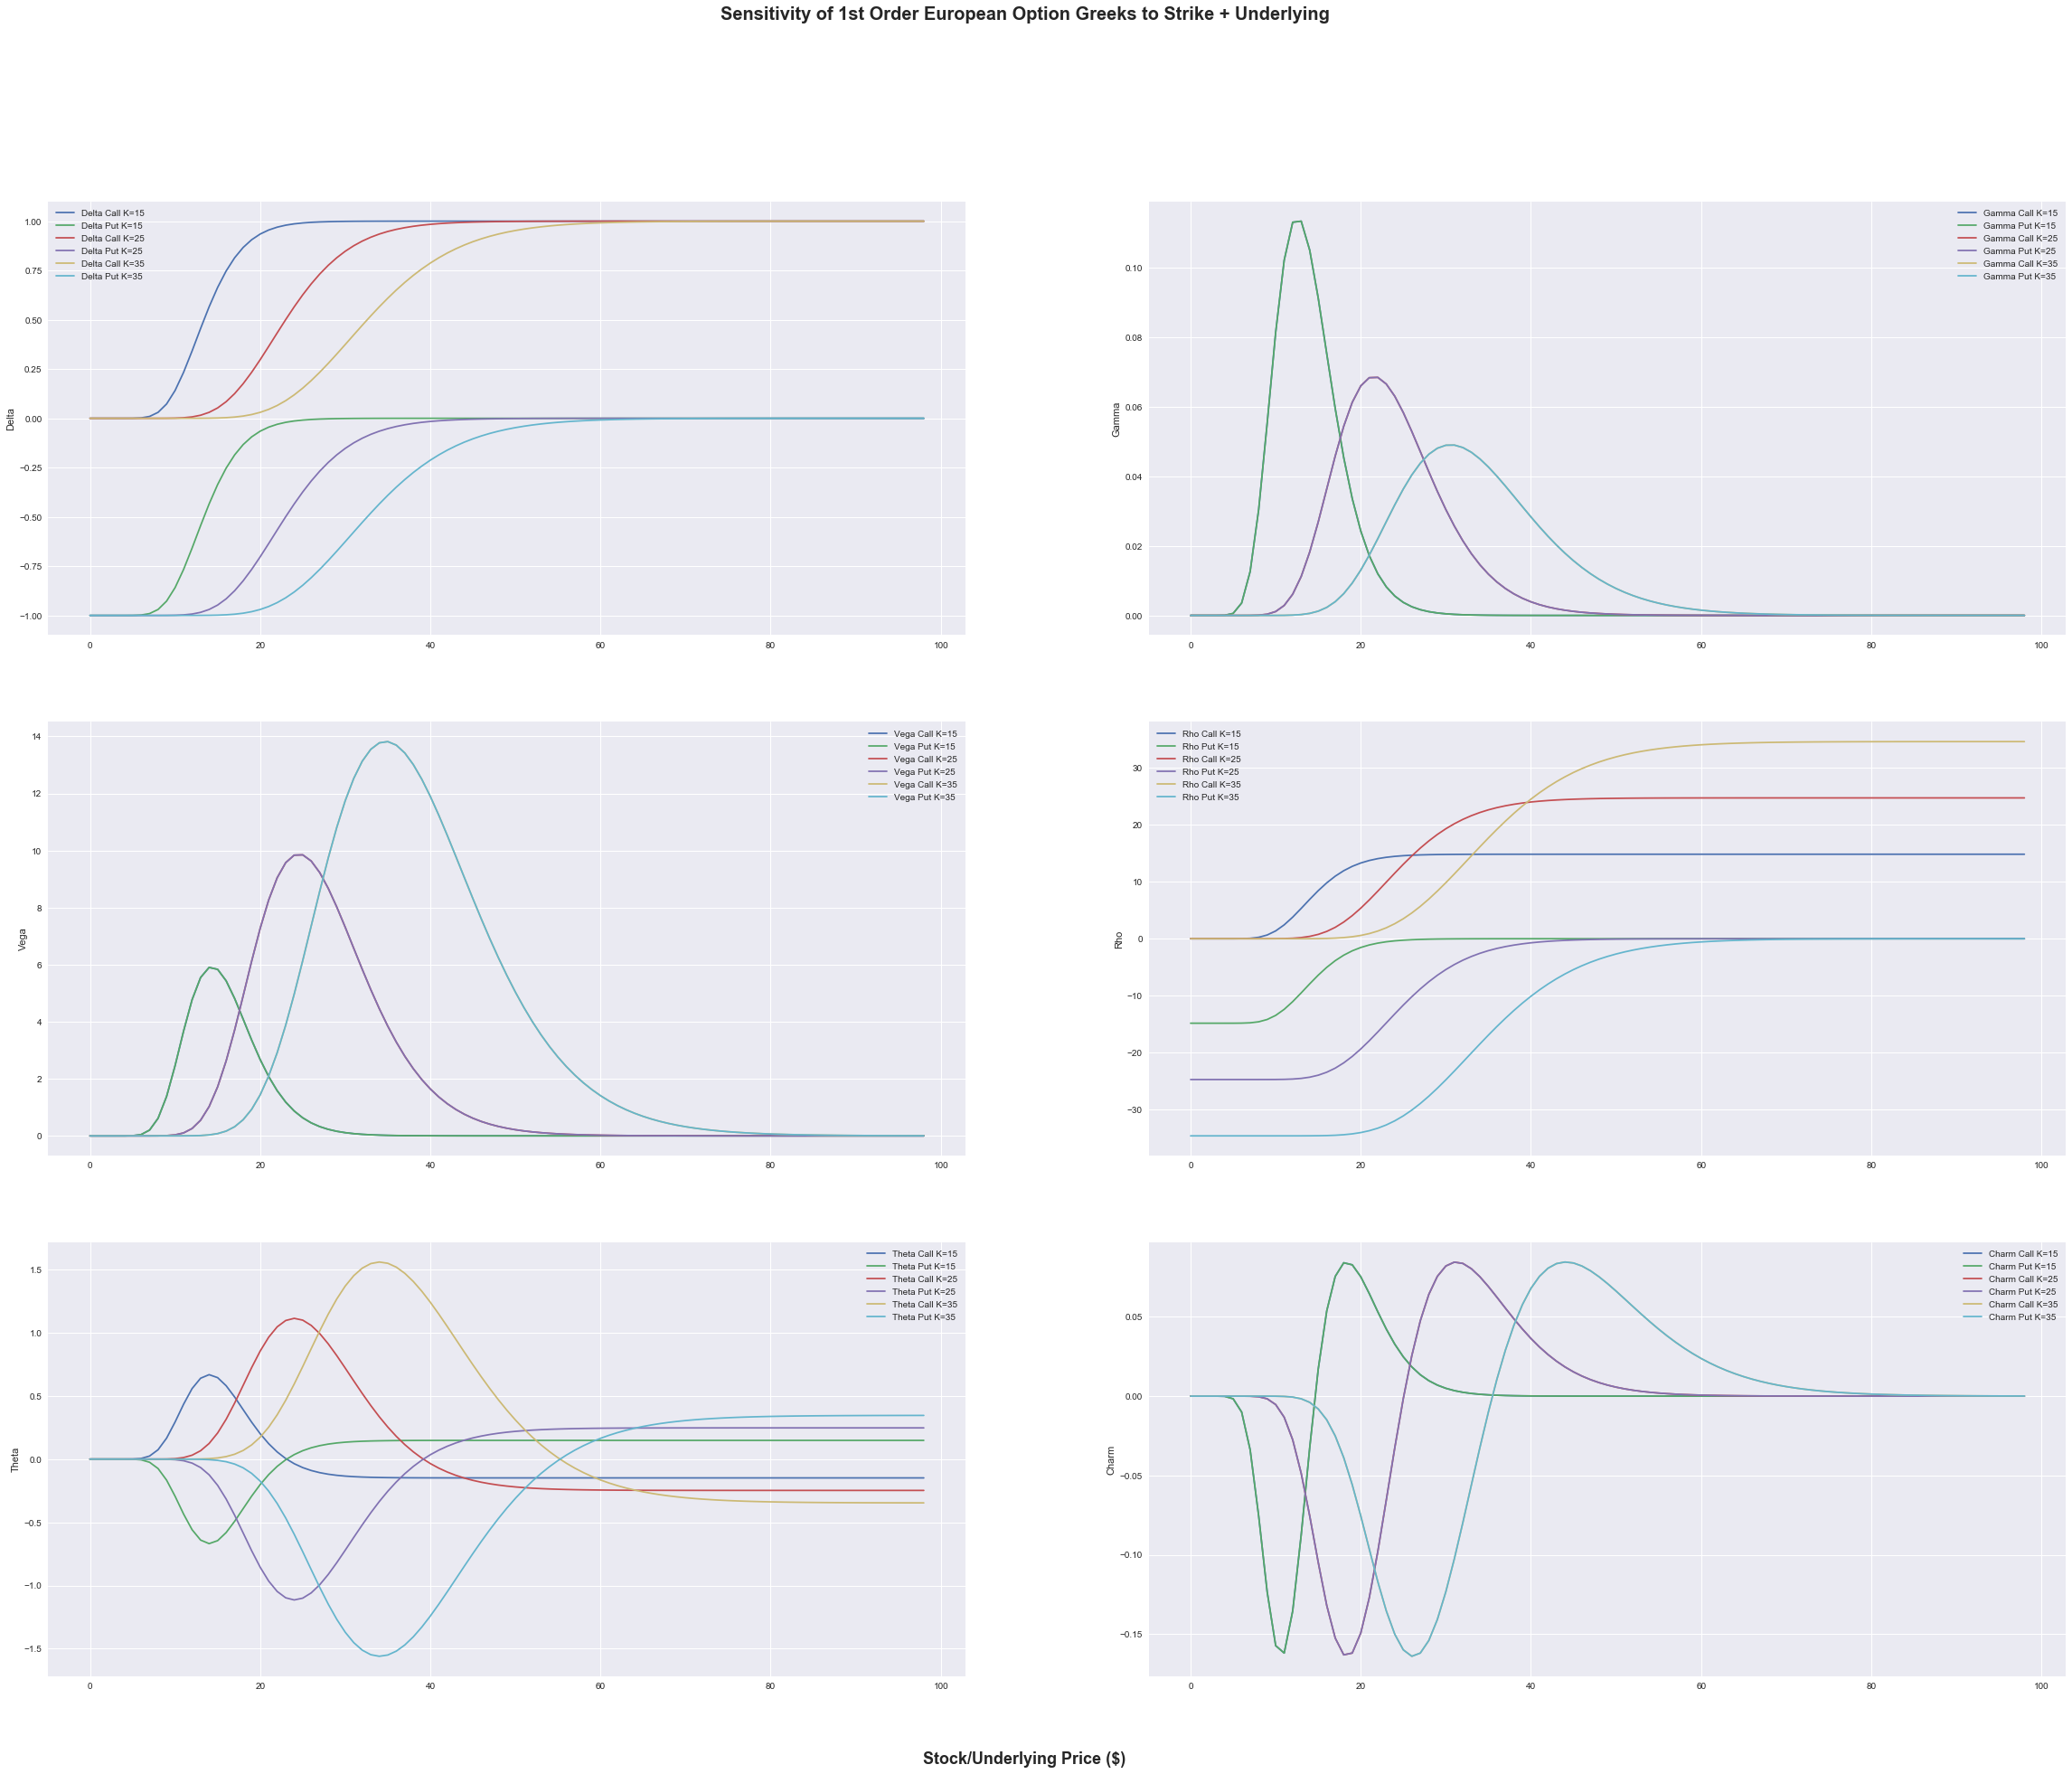

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(40, 30))
fig.suptitle('Sensitivity of 1st Order European Option Greeks to Strike + Underlying', fontsize=20, fontweight='bold')
fig.text(0.5, 0.08, 'Stock/Underlying Price ($)', ha='center', fontsize=18, fontweight='bold')
vals = [15,25,35]

r = 0.01
vol = 0.25
T = 1
t = 0
plt.subplot(321)
for i in vals:
    tmp_c = [delta(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [delta(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Delta Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Delta Put K=%i" % i ))

plt.ylabel("Delta")
plt.legend()

plt.subplot(322)
for i in vals:
    tmp_c = [gamma(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [gamma(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Gamma Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Gamma Put K=%i" % i ))

plt.ylabel("Gamma")
plt.legend()

plt.subplot(323)
for i in vals:
    tmp_c = [vega(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [vega(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Vega Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Vega Put K=%i" % i ))

plt.ylabel("Vega")
plt.legend()

plt.subplot(324)

for i in vals:
    tmp_c = [rho(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [rho(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Rho Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Rho Put K=%i" % i ))

plt.ylabel("Rho")
plt.legend()

plt.subplot(325)
for i in vals:
    tmp_c = [theta(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [theta(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Theta Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Theta Put K=%i" % i ))

plt.ylabel("Theta")
plt.legend()

plt.subplot(326)
for i in vals:
    tmp_c = [charm(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [charm(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Charm Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Charm Put K=%i" % i ))

plt.ylabel("Charm")
plt.legend()
plt.show()

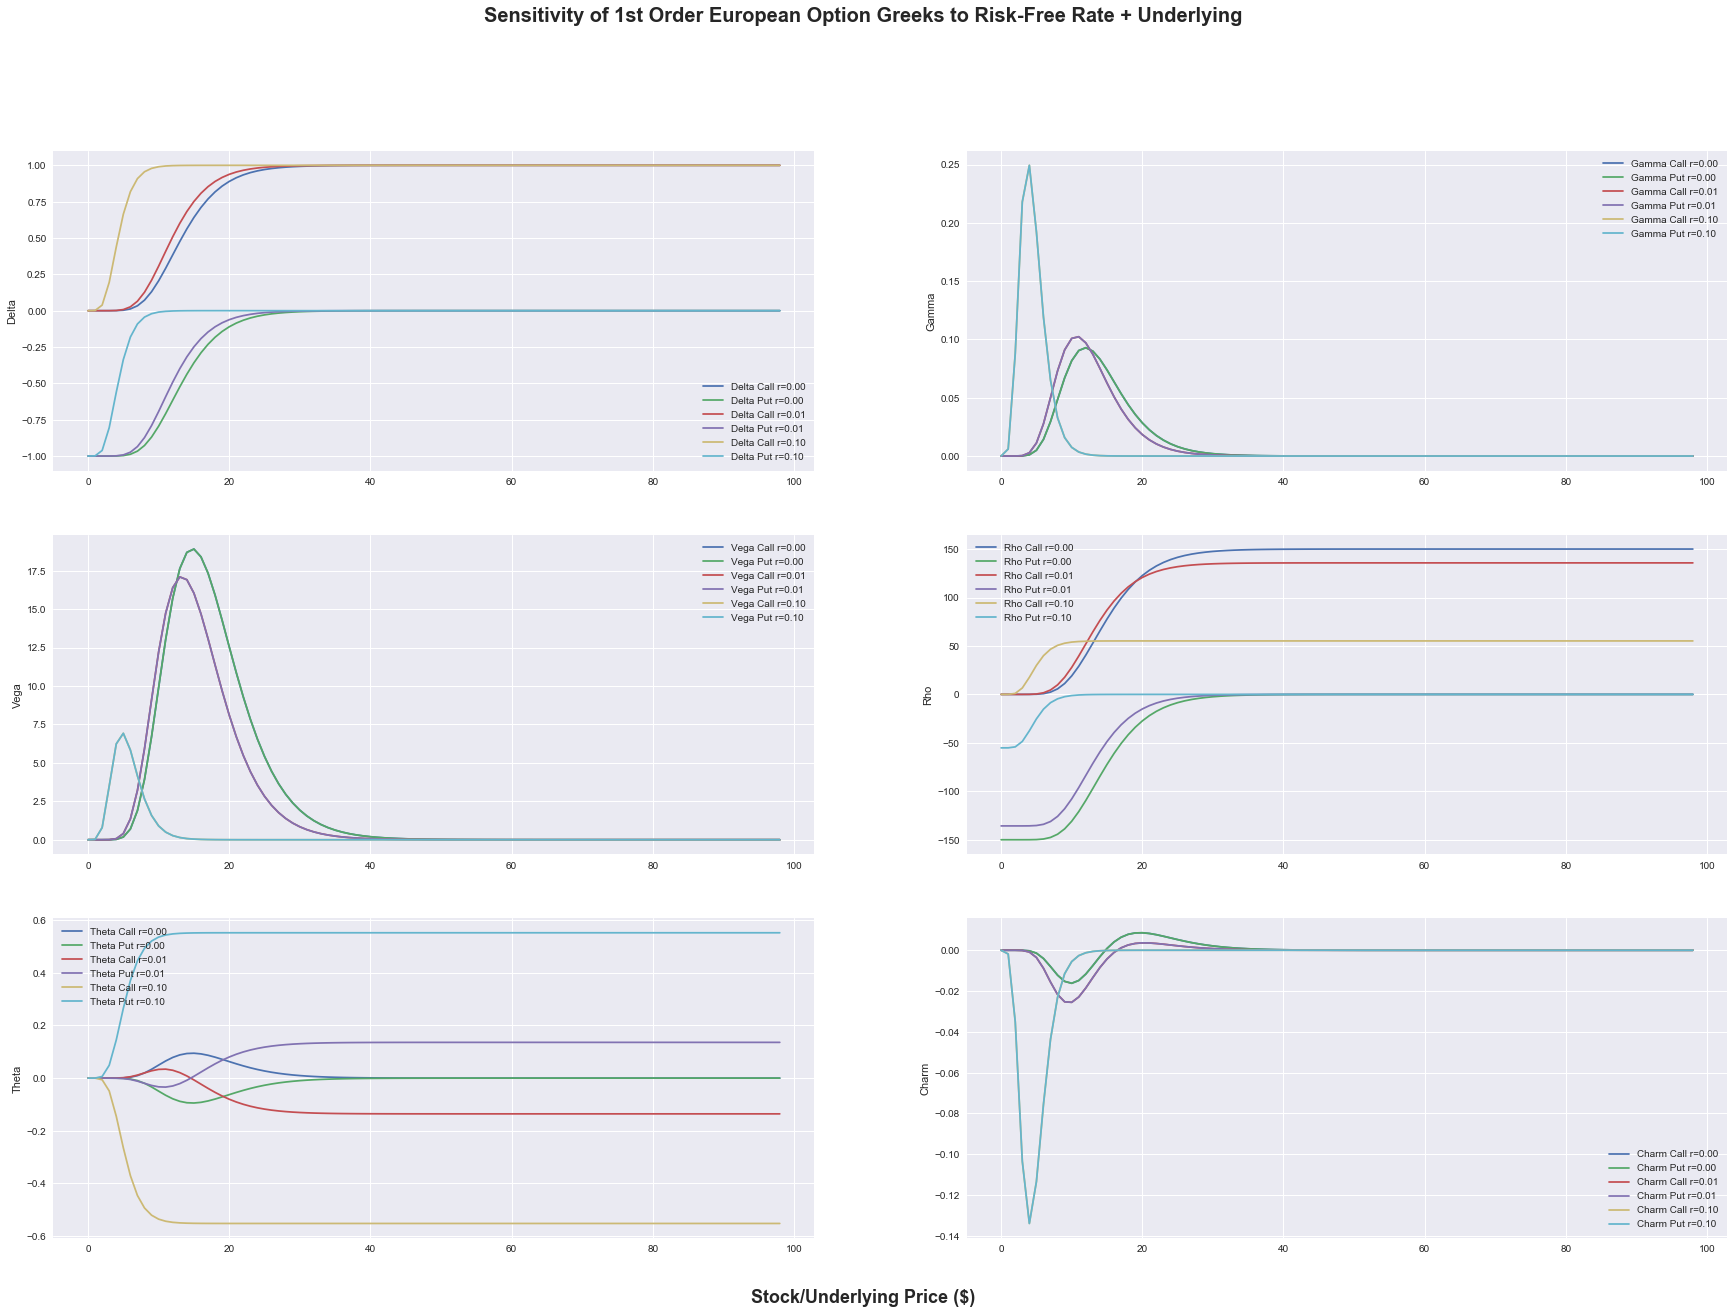

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(30, 20))
fig.suptitle('Sensitivity of 1st Order European Option Greeks to Risk-Free Rate + Underlying', fontsize=20, fontweight='bold')
fig.text(0.5, 0.08, 'Stock/Underlying Price ($)', ha='center', fontsize=18, fontweight='bold')

vals = [0,0.01,0.1]
K = 15
r = 0.01
vol = 0.1
T = 10
t = 0
plt.subplot(321)
for i in vals:
    tmp_c = [delta(s, K, i, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [delta(s, K, i, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Delta Call r=%.2f" % i ))
    plt.plot(tmp_p, label = ("Delta Put r=%.2f" % i ))

plt.ylabel("Delta")
plt.legend()

plt.subplot(322)
for i in vals:
    tmp_c = [gamma(s, K, i, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [gamma(s, K, i, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Gamma Call r=%.2f" % i ))
    plt.plot(tmp_p, label = ("Gamma Put r=%.2f" % i ))

plt.ylabel("Gamma")
plt.legend()

plt.subplot(323)
for i in vals:
    tmp_c = [vega(s, K, i, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [vega(s, K, i, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Vega Call r=%.2f" % i ))
    plt.plot(tmp_p, label = ("Vega Put r=%.2f" % i ))

plt.ylabel("Vega")
plt.legend()

plt.subplot(324)

for i in vals:
    tmp_c = [rho(s, K, i, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [rho(s, K, i, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Rho Call r=%.2f" % i ))
    plt.plot(tmp_p, label = ("Rho Put r=%.2f" % i ))

plt.ylabel("Rho")
plt.legend()

plt.subplot(325)
for i in vals:
    tmp_c = [theta(s, K, i, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [theta(s, K, i, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Theta Call r=%.2f" % i ))
    plt.plot(tmp_p, label = ("Theta Put r=%.2f" % i ))

plt.ylabel("Theta")
plt.legend()

plt.subplot(326)
for i in vals:
    tmp_c = [charm(s, K, i, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [charm(s, K, i, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Charm Call r=%.2f" % i ))
    plt.plot(tmp_p, label = ("Charm Put r=%.2f" % i ))

plt.ylabel("Charm")
plt.legend()
plt.show()

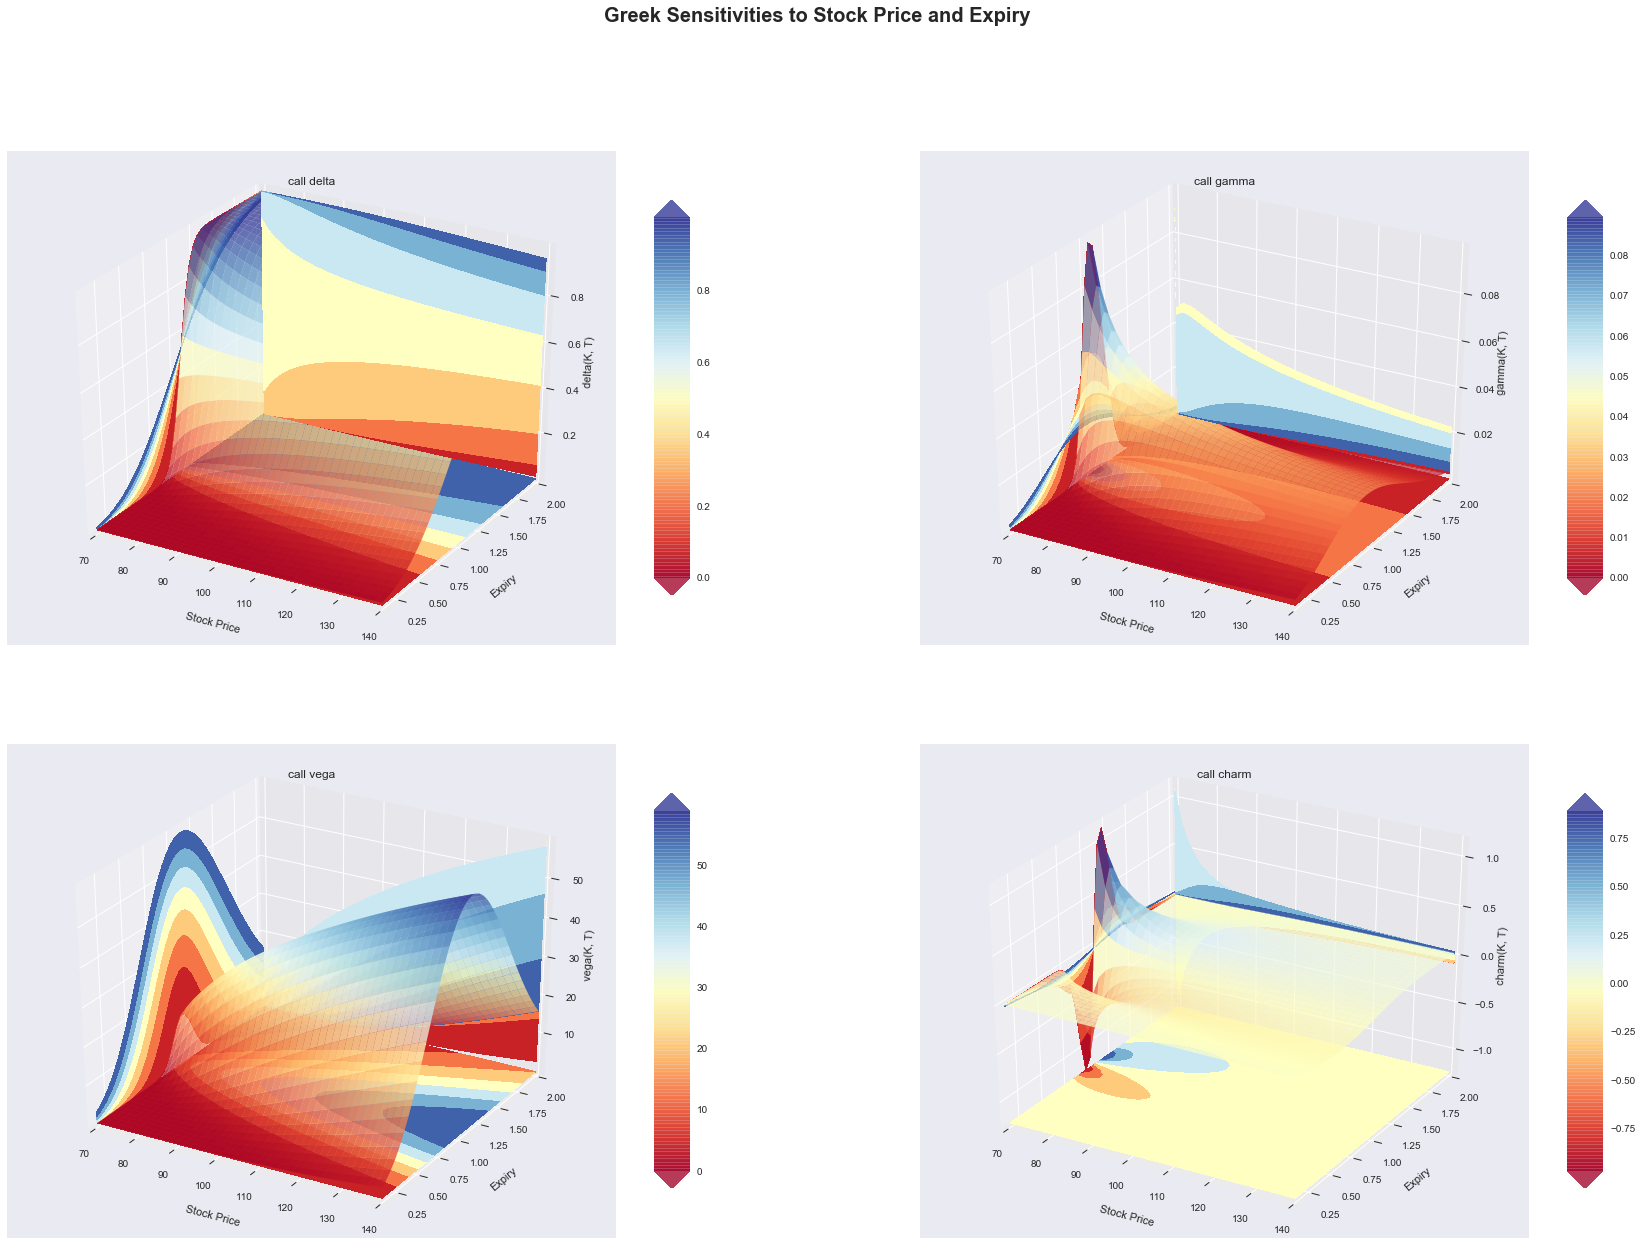

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


# greek_function: input the function we want to calculate over
# x_var_name: 1st variable we vary
# y_var_name: 2nd variable we vary
# S: vector of underlying prices
# K: vector of strike prices
# r: vector of risk free rates
# vol: vector of volatilities
# T: vector of expiry
# t: vector of current date
# x: meshgrid of 1st variable we vary
# y: meshgrid of 2nd variable we vary
# otype: put/call
# plot: plot figure we want to write to
def greeks_plot_tool(greek_function, x_var_name, y_var_name,
                    S, K, r, vol, T, t, x, y, otype, plot):
   
    # Initialise vector to store our option values and then iterate over
    # Assumption that we're using a constant sized vector length for each variable
    # Need to change the variables being iterated over here for each update (possibly a better way to do this)
    V = np.zeros((len(S), len(S)), dtype=np.float)
    for i in range(len(S)):
        for j in range(len(S)):
            V[i, j] = greek_function(S[i], K[i], r[i], vol[i], T[j], t[i], otype)
 
    # Initiliase plotting canvas

    surf = plot.plot_surface(x, y, V, rstride=1, cstride=1,alpha=0.75,cmap=cm.RdYlBu)
    plot.set_xlabel('\n' + x_var_name, linespacing=4)
    plot.set_ylabel('\n' + y_var_name, linespacing=4)
    plot.set_zlabel("%s(K, T)" % greek_function.__name__)
    plot.set_title("%s %s" % (otype, greek_function.__name__))
    
    # Calculate colour levels based on our meshgrid
    Vlevels = np.linspace(V.min(),V.max(),num=8,endpoint=True)
    xlevels = np.linspace(x.min(),x.max(),num=8,endpoint=True)
    ylevels = np.linspace(y.min(),y.max(),num=8,endpoint=True)
    
    cset = plot.contourf(x, y, V, Vlevels, zdir='z',offset=V.min(),
                       cmap=cm.RdYlBu,linestyles='dashed')
    cset = plot.contourf(x, y, V, xlevels, zdir='x',offset=x.min(),
                       cmap=cm.RdYlBu,linestyles='dashed')
    cset = plot.contourf(x, y, V, ylevels, zdir='y',offset=y.max(),
                       cmap=cm.RdYlBu,linestyles='dashed')

    # Set our viewing constraints
    for c in cset.collections:
        c.set_dashes([(0, (2.0, 2.0))]) # Dash contours

    plt.clabel(cset,fontsize=10, inline=1)
    plot.set_xlim(x.min(),x.max())
    plot.set_ylim(y.min(),y.max())
    plot.set_zlim(V.min(),V.max())

    # Colorbar
    colbar = plt.colorbar(surf, shrink=1.0, extend='both', aspect = 10)
    l,b,w,h = plt.gca().get_position().bounds
    ll,bb,ww,hh = colbar.ax.get_position().bounds
    colbar.ax.set_position([ll, b+0.1*h, ww, h*0.8])
    
        
S = np.linspace(70, 140, 40)
K = np.linspace(105.0, 105.0, 40)
T = np.linspace(0.1, 2.0, 40)
t = np.linspace(0.0, 0.0, 40)
r = np.linspace(0.0, 0.0, 40)
vol = np.linspace(0.12, 0.12, 40)

x, y  = np.meshgrid(S, T)

fig = plt.figure(figsize=(30,20))
fig.suptitle("Greek Sensitivities to Stock Price and Expiry",fontsize=20, fontweight='bold')
greeks = [delta, gamma, vega, charm]

for i in range(len(greeks)):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    greeks_plot_tool(greeks[i],"Stock Price", "Expiry", S, K, r, vol, T, t, x, y, "call", ax)

plt.show()
